# Following the scRNA-seq reads (from bam file)

Goal: Make a confusion matrix showing where each read aligns to before personalization

In [1]:
#load library
suppressPackageStartupMessages({
    library(Rsamtools)
    library(tidyr)
    #library(ggVennDiagram)
    library(rtracklayer)
    library(Biostrings)
    library(Matrix)
    library(tidyverse)
    library(viridis)
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}

## Dive into bam files

Get genomic ranges from gtf file:

In [2]:
df = as.data.frame(matrix(nrow = 8, ncol = 3))
colnames(df) = c('gene', 'start', 'end')
annotations = rtracklayer::import('/data/srlab1/amber_joyce/filtered_gtf/gencode.v38.annotation.filtered.gtf')
classical = c('HLA-A', 'HLA-B', 'HLA-C', 'HLA-DRB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DPA1', 'HLA-DPB1')

for (i in 1:length(classical)) {
    classical_annotation = annotations[which(annotations$gene_name == classical[i] &
                                          annotations$type == 'gene'),]
    start = start(ranges(classical_annotation))
    end = end(ranges(classical_annotation))
    df[i, 'gene'] = classical[i]
    df[i, 'start'] = start
    df[i, 'end'] = end
}
rownames(df) = df$gene
df

,gene,start,end
,<chr>,<int>,<int>
HLA-A,HLA-A,29941260,29945884
HLA-B,HLA-B,31353872,31357188
HLA-C,HLA-C,31268749,31272130
HLA-DRB1,HLA-DRB1,32578769,32589848
HLA-DQA1,HLA-DQA1,32628179,32647062
HLA-DQB1,HLA-DQB1,32659467,32668383
HLA-DPA1,HLA-DPA1,33064569,33080775
HLA-DPB1,HLA-DPB1,33075990,33089696


In [3]:
DPB1_annotation = annotations[which(annotations$gene_name == 'HLA-DPB1'), ] %>% as.data.frame()
DPB1_annotation %>% head()

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,⋯,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,havana_transcript,exon_number,exon_id,protein_id,ccdsid
,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr6,33075990,33089696,13707,+,HAVANA,gene,NA,NA,ENSG00000223865.11,⋯,OTTHUMG00000031076.7,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,chr6,33075990,33089696,13707,+,HAVANA,transcript,NA,NA,ENSG00000223865.11,⋯,OTTHUMG00000031076.7,ENST00000418931.7,protein_coding,HLA-DPB1-211,NA,OTTHUMT00000076106.3,NA,NA,ENSP00000408146.2,CCDS4765.1
3,chr6,33075990,33076141,152,+,HAVANA,exon,NA,NA,ENSG00000223865.11,⋯,OTTHUMG00000031076.7,ENST00000418931.7,protein_coding,HLA-DPB1-211,NA,OTTHUMT00000076106.3,1,ENSE00001911406.2,ENSP00000408146.2,CCDS4765.1
4,chr6,33076042,33076141,100,+,HAVANA,CDS,NA,0,ENSG00000223865.11,⋯,OTTHUMG00000031076.7,ENST00000418931.7,protein_coding,HLA-DPB1-211,NA,OTTHUMT00000076106.3,1,ENSE00001911406.2,ENSP00000408146.2,CCDS4765.1
5,chr6,33076042,33076044,3,+,HAVANA,start_codon,NA,0,ENSG00000223865.11,⋯,OTTHUMG00000031076.7,ENST00000418931.7,protein_coding,HLA-DPB1-211,NA,OTTHUMT00000076106.3,1,ENSE00001911406.2,ENSP00000408146.2,CCDS4765.1
6,chr6,33080672,33080935,264,+,HAVANA,exon,NA,NA,ENSG00000223865.11,⋯,OTTHUMG00000031076.7,ENST00000418931.7,protein_coding,HLA-DPB1-211,NA,OTTHUMT00000076106.3,2,ENSE00003632368.1,ENSP00000408146.2,CCDS4765.1


## Submit for all samples as jobs

In [4]:
script = './bam_confusion.R'
logs_dir = './logs/'

# Send jobs for Randolph2021
results_noPers_dir = paste0('/data/srlab2/jkang/scHLA/noPers_final/Randolph2021_NewPanel/STARsolo_results/')
results_pers_dir = paste0('/data/srlab2/jkang/scHLA/personalized_final/Randolph2021_NewPanel/STARsolo_results/')
sample_meta = read.csv(paste0('../../data/meta/sample_meta_Randolph_completeHLA.csv'))
for (sample in sample_meta$Sample) {
    s = paste0('bsub -q big-multi -M 20000 -R "rusage[mem=20000]" -J bam_cm_', sample,
                   ' -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]"', 
                    ' -o ', logs_dir, 'bam_cm_', sample, '.out -e ', logs_dir, 'bam_cm_', sample, '.err',
                   ' "Rscript ', script, ' ', 
                   paste(sample, results_noPers_dir, results_pers_dir), '"')
    system(s)
}

# Send jobs for AMP2RA
results_noPers_dir = paste0('/data/srlab2/jkang/scHLA/noPers_final/AMP2RA_NewPanel/STARsolo_results/')
results_pers_dir = paste0('/data/srlab2/jkang/scHLA/personalized_final/AMP2RA_NewPanel/STARsolo_results/')
sample_meta = read.csv(paste0('../../data/meta/sample_meta_AMP2RA_completeHLA.csv'))
for (sample in sample_meta$Sample) {
    s = paste0('bsub -q big-multi -M 20000 -R "rusage[mem=20000]" -J bam_cm_', sample,
                   ' -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]"', 
                    ' -o ', logs_dir, 'bam_cm_', sample, '.out -e ', logs_dir, 'bam_cm_', sample, '.err',
                   ' "Rscript ', script, ' ', 
                   paste(sample, results_noPers_dir, results_pers_dir), '"')
    system(s)
}

# Send jobs for OneK1K
results_noPers_dir = paste0('/data/srlab2/jkang/scHLA/noPers_final/OneK1K_NewPanel/STARsolo_results/')
results_pers_dir = paste0('/data/srlab2/jkang/scHLA/personalized_final/OneK1K_NewPanel/STARsolo_results/')
sample_meta = read.csv(paste0('../../data/meta/sample_meta_OneK1K_completeHLA.csv'))
for (sample in sample_meta$Sample) {
    s = paste0('bsub -q big-multi -M 20000 -R "rusage[mem=20000]" -J bam_cm_', sample,
                   ' -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]"', 
                    ' -o ', logs_dir, 'bam_cm_', sample, '.out -e ', logs_dir, 'bam_cm_', sample, '.err',
                   ' "Rscript ', script, ' ', 
                   paste(sample, results_noPers_dir, results_pers_dir), '"')
    system(s)
}

## Plot results - Randolph

### Following the pers reads

In [4]:
sample_meta = read.csv(paste0('../../data/meta/sample_meta_Randolph_completeHLA.csv'))
full_results = NULL
for (sample in sample_meta$Sample) {
    result_noPers = readRDS(paste0('/data/srlab1/jkang/hla/notebooks/220906_bam_confusion/', sample, '_noPers_read_alignments.rds'))
    result_noPers$sample = sample
    full_results = rbind(full_results, result_noPers)
}
full_results = full_results %>% group_by(paste(noPers_read_alignment, pers_read_alignment, sep = '_')) %>%
    summarise(total = sum(n))

colnames(full_results) = c('label', 'total')
full_results = tidyr::separate(full_results, col = 'label', into =  c("noPers_read_alignment", "pers_read_alignment"), "_")

#normalize each row
gene_sums = full_results %>% group_by(pers_read_alignment) %>% summarize(total_for_gene = sum(total))
normalized_results = merge(full_results, gene_sums) %>% 
    mutate(pct_pers_read_alignments = 100*round(total / total_for_gene, 3))

normalized_results = normalized_results %>% filter(pct_pers_read_alignments > 0.0)

png 
  2

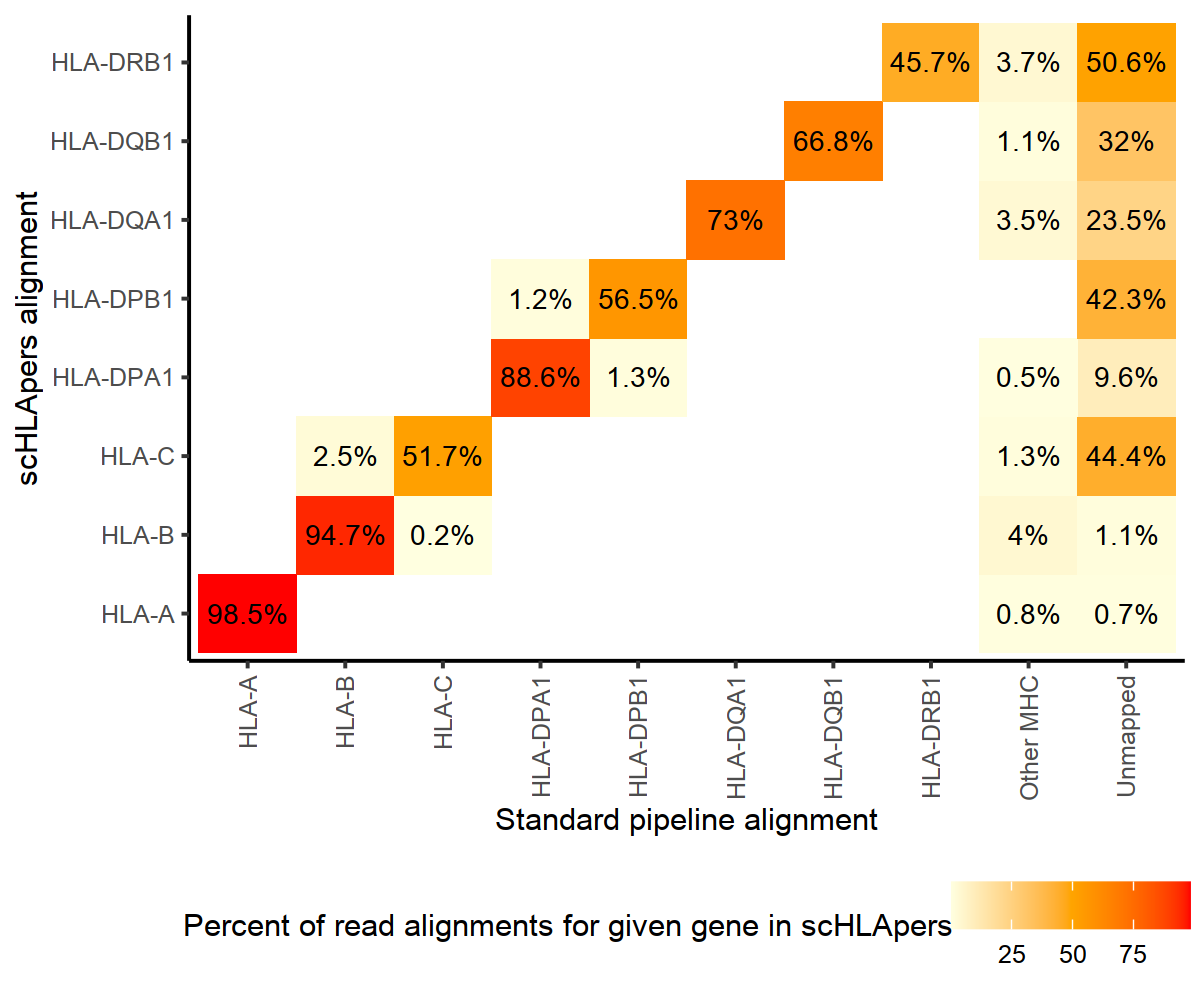

In [5]:
fig.size(5, 6)
pdf('../../SuppFigs/Bam_confusion_matrix_Randolph_readsAligningInPers.pdf', width = 6, height = 5)
p = ggplot(normalized_results, aes(x = noPers_read_alignment, y = pers_read_alignment)) +
    geom_tile(aes(fill = pct_pers_read_alignments)) +
    geom_text(aes(label = paste0(pct_pers_read_alignments, '%')), color = "black", size = 3.5) +
    theme_classic() + 
    #ggtitle('Tracking the origin of reads aligning in scHLApers (Randolph2021)') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    theme(legend.position = 'bottom') + xlab('Standard pipeline alignment') + ylab('scHLApers alignment') +
    labs(fill = 'Percent of read alignments for given gene in scHLApers') +
    scale_fill_gradientn(colours = c("lightyellow", "orange", "red"), values = c(0, 0.5, 1))
print(p)
dev.off()
p

(Rows sum to 100%)

## Plot results - AMP2RA

### Following the pers reads

png 
  2

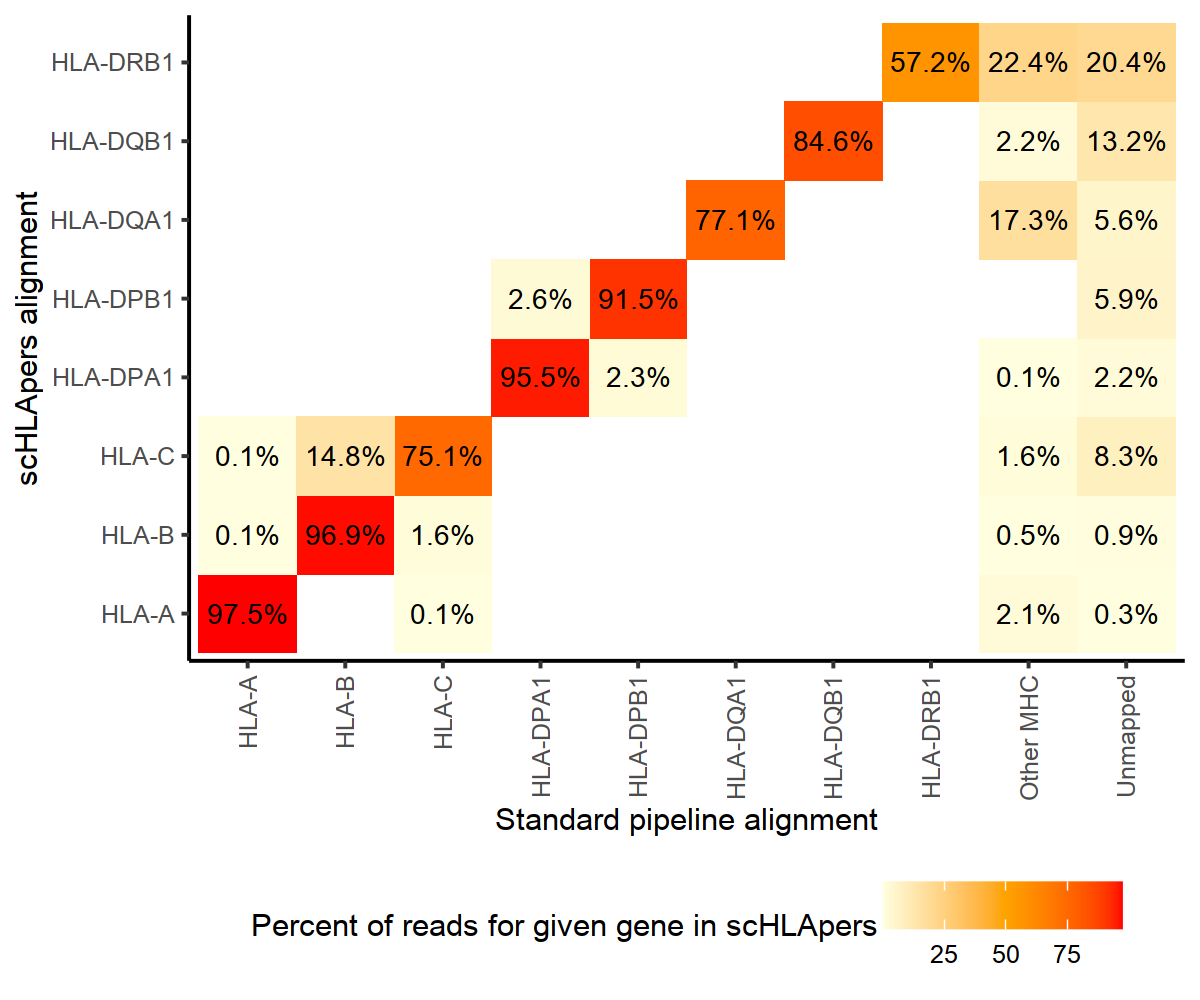

In [6]:
sample_meta = read.csv(paste0('../../data/meta/sample_meta_AMP2RA_completeHLA.csv'))
full_results = NULL
for (sample in sample_meta$Sample) {
    result_noPers = readRDS(paste0('/data/srlab1/jkang/hla/notebooks/220906_bam_confusion/', sample, '_noPers_read_alignments.rds'))
    result_noPers$sample = sample
    full_results = rbind(full_results, result_noPers)
}
full_results = full_results %>% group_by(paste(noPers_read_alignment, pers_read_alignment, sep = '_')) %>%
    summarise(total = sum(n))

colnames(full_results) = c('label', 'total')
full_results = tidyr::separate(full_results, col = 'label', into =  c("noPers_read_alignment", "pers_read_alignment"), "_")

#normalize each row
gene_sums = full_results %>% group_by(pers_read_alignment) %>%
    summarize(total_for_gene = sum(total))
normalized_results = merge(full_results, gene_sums) %>% 
    mutate(pct_pers_read_alignments = 100*round(total / total_for_gene, 3))

normalized_results = normalized_results %>% filter(pct_pers_read_alignments > 0.0)

fig.size(5, 6)
pdf('../../SuppFigs/Bam_confusion_matrix_AMP2RA_readsAligningInPers.pdf', width = 6, height = 5)
p = ggplot(normalized_results, aes(x = noPers_read_alignment, y = pers_read_alignment)) +
    geom_tile(aes(fill = pct_pers_read_alignments)) +
    geom_text(aes(label = paste0(pct_pers_read_alignments, '%')), color = "black", size = 3.5) +
    theme_classic() + 
    #ggtitle('Tracking the origin of reads aligning in scHLApers (AMP2RA)') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    theme(legend.position = 'bottom') + xlab('Standard pipeline alignment') + ylab('scHLApers alignment') +
    labs(fill = 'Percent of reads for given gene in scHLApers') +
    scale_fill_gradientn(colours = c("lightyellow", "orange", "red"), values = c(0, 0.5, 1))
print(p)
dev.off()
p

(Rows sum to 100%)

# All done!

In [8]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/hla_new/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] viridis_0.6.2        viridisLite_0.4.1    forcats_0.5.1       
 [4] stringr_1.4.0        dplyr_1.0.8          purrr_0.3.4         
 [7] readr_2.1.2          tibble_3.1.6         ggplot2_3.3.5       
[10] tidyverse_1.3.1      Matrix_1.4-0